# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future prices from past price movements.
Here we implement it with EUR/USD rate as an example, but you can convert it to stock price by editing the symbol.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-28,1.098189,1.099674,1.094535,1.098189,1.098189,0
2022-03-29,1.099384,1.113635,1.097045,1.099384,1.099384,0
2022-03-30,1.109152,1.117000,1.108906,1.109152,1.109152,0
2022-03-31,1.116184,1.118306,1.107400,1.116184,1.116184,0
2022-04-01,1.107236,1.107542,1.102974,1.107236,1.107236,0


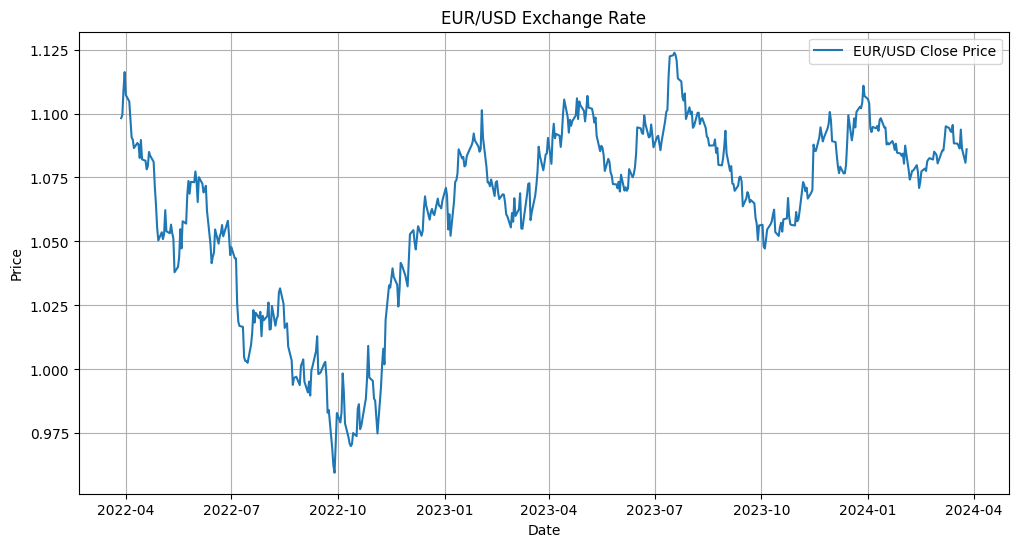

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf  # Import yfinance for data retrieval
import matplotlib.pyplot as plt
import joblib
from IPython.display import display

%matplotlib inline

# Define the ticker symbol for EUR/USD
ticker_symbol = 'EURUSD=X'
ticker_interval = '1d' # change this to adjust granularity and train a separate model on that granularity. Options: 15m, 30m, 1h, 1d.

def fetch_data():
    try:
        if ticker_interval == '1d':
            ticker_period = '2y'
            data = yf.download(ticker_symbol, period=ticker_period, progress=False)
        else:
            ticker_period = '1mo'
            data = yf.download(ticker_symbol, period=ticker_period, interval=ticker_interval, progress=False)
        return data
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

try:
    # fetching last 60 days of data with 15min granularity because-
    # i thought it'll be more optimal to train the model on.
    data = fetch_data()

    # Display the first few rows of the data
    display(data.head())

    # You can now work with the 'data' DataFrame for your analysis or plotting.
    
    # Example: Plotting the Close prices
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='EUR/USD Close Price')
    plt.title('EUR/USD Exchange Rate')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
except Exception as e:
    print(f"An error occurred: {str(e)}")


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-28,0.91059,0.909360,0.913630,0.91059,0.91059,0
2022-03-29,0.90960,0.897960,0.911540,0.90960,0.90960,0
2022-03-30,0.90159,0.895255,0.901790,0.90159,0.90159,0
2022-03-31,0.89591,0.894210,0.903016,0.89591,0.89591,0
2022-04-01,0.90315,0.902900,0.906640,0.90315,0.90315,0


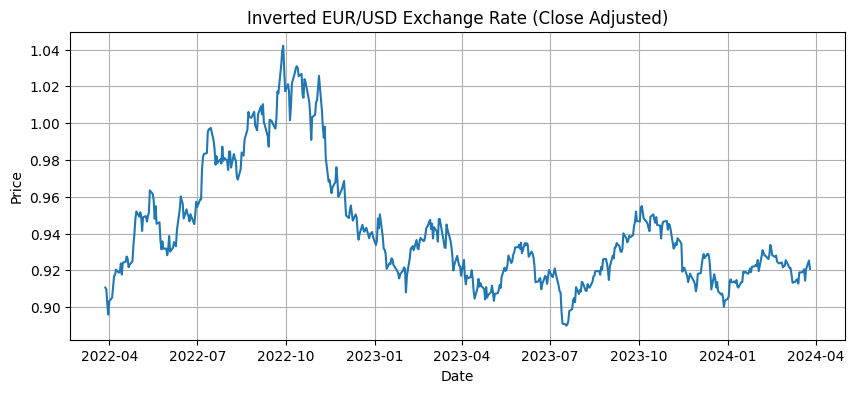

In [2]:
# Put data into Pandas Dataframe
df = pd.DataFrame(data)
df[['Open','High','Low','Close','Adj Close']] = df[['Open','High','Low','Close','Adj Close']].apply(lambda x: 1.0/x)
# Display the first few rows of the DataFrame
display(df.head())

# Plot the 'Close Adjusted' column
plt.figure(figsize=(10, 4))
plt.plot(df['Adj Close'], label='Inverted Close Adjusted Price')
plt.title('Inverted EUR/USD Exchange Rate (Close Adjusted)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

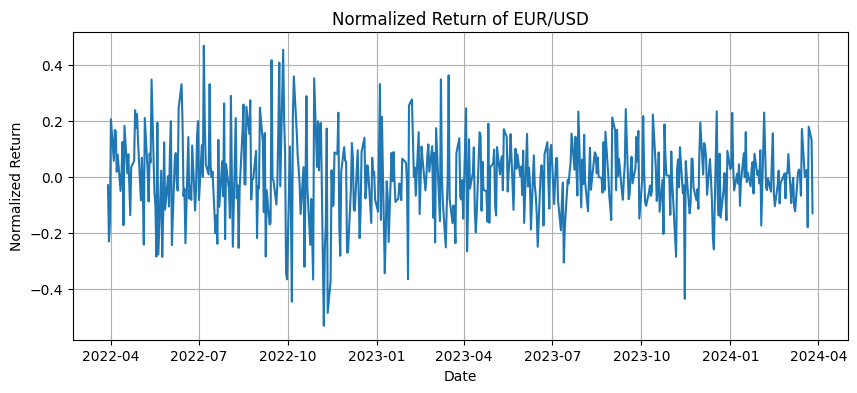

In [3]:
# Normalize aclose value and plot 'return' column
df['Return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['Return'].max() - df['Return'].min()
df['Return'] = df['Return'] / return_range

plt.figure(figsize=(10, 4))
plt.plot(df['Return'], label='Return')
plt.title('Normalized Return of EUR/USD')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.grid(True)
plt.show()


In [4]:
# Make label, 1 as rising price, 0 as falling price
df['Label'] = df['Return'].shift(-1)
df['Label'] = df['Label'].apply(lambda x: 1 if x > 0.0 else 0)

# Display the tail of the DataFrame with labels
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Return,Label
Date,,,,,,,,
2024-03-20,0.92053,0.9196,0.92277,0.92053,0.92053,0,0.025783,0
2024-03-21,0.91431,0.9137,0.92111,0.91431,0.91431,0,-0.178176,1
2024-03-22,0.92061,0.9200,0.92515,0.92061,0.92061,0,0.180468,1
2024-03-25,0.92528,0.9222,0.92570,0.92528,0.92528,0,0.133772,0
2024-03-26,0.92250,0.9206,0.92260,0.92080,0.92080,0,-0.128332,0


In [5]:

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

n_features = 13  # number of features

train_x = np.array([]).reshape([-1, n_features])
train_y = np.array([]).reshape([-1, 1])

# Check if 'Label' is in the columns of your DataFrame
if 'Label' not in df.columns:
    print("The 'Label' column does not exist in your DataFrame.")
else:
    for index, row in df.iterrows():
        i = df.index.get_loc(index)
        if i < n_features:
            continue

        _x = np.array(df[i - n_features + 1:i + 1]['Return']).T.reshape([1, -1])
        print(df)
        _y = df.loc[i, 'Label']  # Use 'loc' method to access DataFrame values

        train_x = np.vstack((train_x, _x))
        train_y = np.vstack((train_y, _y))

    # Reshape train_y to 1D array
    train_y = train_y.reshape(-1)

    print(train_x.shape)
    print(train_y.shape)
    print('%% of Class 0: %f' % (np.count_nonzero(train_y == 0) / float(len(train_y))))
    print('%% of Class 1: %f' % (np.count_nonzero(train_y == 1) / float(len(train_y))))


        Open      High       Low    Close  Adj Close  Volume    Return  Label
0    0.91059  0.909360  0.913630  0.91059    0.91059       0       NaN      0
1    0.90960  0.897960  0.911540  0.90960    0.90960       0 -0.028357      0
2    0.90159  0.895255  0.901790  0.90159    0.90159       0 -0.229448      0
3    0.89591  0.894210  0.903016  0.89591    0.89591       0 -0.162704      1
4    0.90315  0.902900  0.906640  0.90315    0.90315       0  0.207390      1
..       ...       ...       ...      ...        ...     ...       ...    ...
517  0.92053  0.919600  0.922770  0.92053    0.92053       0  0.025783      0
518  0.91431  0.913700  0.921110  0.91431    0.91431       0 -0.178176      1
519  0.92061  0.920000  0.925150  0.92061    0.92061       0  0.180468      1
520  0.92528  0.922200  0.925700  0.92528    0.92528       0  0.133772      0
521  0.92250  0.920600  0.922600  0.92080    0.92080       0 -0.128332      0

[522 rows x 8 columns]
        Open      High       Low    Clos

In [6]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.0016, n_estimators=10000)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.615385


,Return,Label,Pred,Won,Pnl,Equity
20,0.00090,1.0,1.0,True,9.000722,83.104075
21,-0.00622,0.0,1.0,False,-62.201115,20.902961
22,0.00630,1.0,1.0,True,63.001223,83.904184
23,0.00467,1.0,1.0,True,46.699578,130.603762
24,-0.00448,0.0,0.0,True,44.800784,175.404546


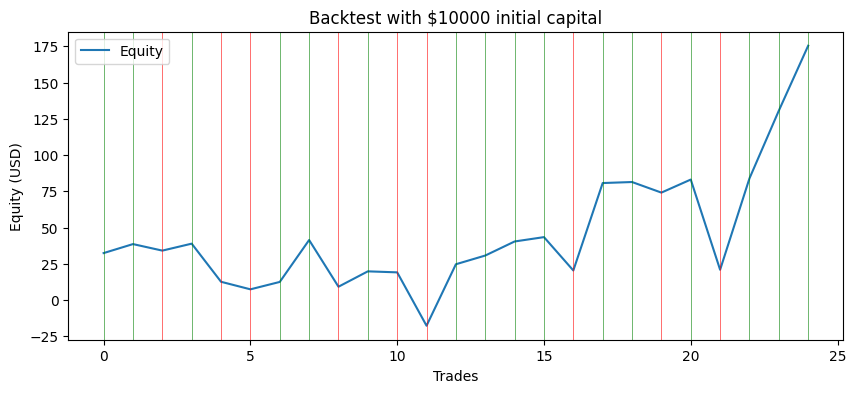

In [7]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['Return'])
df_trade['Label']  = train_y[train_len:]
df_trade['Pred']   = pred
df_trade['Won']    = df_trade['Label'] == df_trade['Pred']
df_trade['Return'] = df_trade['Return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['Won']:
        return abs(row['Return'])*contracts - commission
    else:
        return -abs(row['Return'])*contracts - commission

df_trade['Pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['Equity'] = df_trade['Pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='Equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['Won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $175.40
Number Winning Trades : 16
Number Losing Trades  : 9
Percent Profitable    : 64.00%
Avg Win Trade         : $23.350
Avg Los Trade         : $-22.022
Largest Win Trade     : $63.001
Largest Los Trade     : $-62.201
Profit Factor         : 1.88


<Axes: >

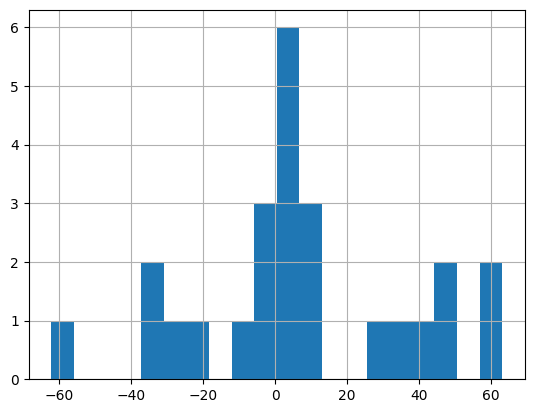

In [8]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['Pnl']>0.0]['Pnl'].count())
n_los_trades = float(df_trade[df_trade['Pnl']<0.0]['Pnl'].count())
print("Net Profit            : $%.2f" % float(df_trade.tail(1)['Equity'].iloc[0]))
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['Pnl']>0.0]['Pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['Pnl']<0.0]['Pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['Pnl']>0.0]['Pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['Pnl']<0.0]['Pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['Pnl']>0.0]['Pnl'].sum()/df_trade[df_trade['Pnl']<0.0]['Pnl'].sum()))

df_trade['Pnl'].hist(bins=20)

In [9]:
import os

# Get the parent directory of the notebook's directory
parent_directory = os.path.dirname(os.getcwd())

# Define the directory path for saving the model within the "models" directory
model_directory = os.path.join(parent_directory, "models")

# Create the "models" directory if it doesn't exist
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Define the file path for saving the model
model_filename = os.path.join(model_directory, f"{ticker_interval}.h5")

# Save the trained model to a file
joblib.dump(clf, model_filename)

# Print a message to confirm the model has been saved
print("Trained model saved to", model_filename)

Trained model saved to c:\Users\infin\OneDrive\Desktop\pyre-trader\models\1d.h5
